<a href="https://colab.research.google.com/github/Jakiminski/Glaucoma-Detection/blob/preproc%2Bsplitdatabase/Detec%C3%A7%C3%A3o_de_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detecção de Glaucoma em exames de Fundoscopia**

# **Organizar os arquivos**

In [ ]:
import os, os.path # Miscellaneous Operating System Interfaces

!pip install --upgrade pip # Update pip
!pip install scikit-image # add scikit no projeto, para o import
!pip install scikit-learn -U # add scikit no projeto, para o import
!pip install -U imbalanced-learn

!pip install git+https://github.com/ypeleg/nfnets-keras


# extração do dataset no Kaggle
!pip install kaggle
# Chave de uma conta do Kaggle (login no Kaggle, então: Profile>Account>API, criar API token, baixando kaggle.json)
os.environ['KAGGLE_USERNAME'] = 'jakijonas'
os.environ['KAGGLE_KEY'] = '62658aedc8305f0d14232ab83046ea1d'
# Extrair e Importar o Dataset do Reconhecimento de Doenças Oculares
!kaggle datasets list -s andrewmvd/ocular-disease-recognition-odir5k # list datasets matching a search term
# download files associated with a dataset
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k --force 
!unzip -q ocular-disease-recognition-odir5k.zip # Descompactar
# Remover arquivos desnecessários
!rm ocular-disease-recognition-odir5k.zip 
!rm -r -f sample_data/
!rm -r -f preprocessed_images/


     |████████████████████████████████| 1.6 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 23.1 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 189 kB 5.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
  Cloning https://github.com/ypeleg/nfnets-keras to /tmp/pip-req-build-3fy3xgqe
  Running command git clone -q https://github.com/ypeleg/nfnets-keras /tmp/pip-req-build-3fy3xgqe
  Resolved https://github.com/ypeleg/nfnets-keras to commit 62cb8da90ab51e7949afac4ea4fced4902869e77
  Created wheel f

In [ ]:
# Esse trecho é responsavel por organizar dentro dos arquivos corretos
# cada imagem. Dessa forma, as imagens classificadas com
# GLAUCOMA foram para o diretório database/1 e as imagens
# classificadas como NORMAIS foram para o diretorio database/0
import pandas as pd
import shutil
import random

if (not os.path.exists('database')):
  os.mkdir('database')
  os.mkdir('database/0')
  os.mkdir('database/1')

col_list = ['filename', 'filepath','N','G']
df = pd.read_csv('full_df.csv')
df.head()
# NO CSV, as seguintes colunas:
# coluna [04] = filename
# coluna [08] = NORMAL
# coluna [10] = GLAUCOMA
# coluna [16] = filepath

itertuples = df.itertuples(name=None) 

#print('tamanho da itertuples:\t{}'.format(len(df)))

normal_count = 0
glaucoma_count = 0


for i in itertuples:
  filename = i[4]
  source = 'ODIR-5K/'+ i[16][43:]
  #print('source: \'{}\''.format(source))
  N = i[8]
  G = i[10]

  if(N==1):
    normal_count += 1
    normal_dir = 'database/0/'+str(normal_count)+filename
    shutil.copy(source, normal_dir)
  elif(G==1):
    glaucoma_count += 1
    glaucoma_dir = 'database/1/'+str(glaucoma_count)+filename
    shutil.copy(source, glaucoma_dir)

print('arquivos classe 0 (Normal):\t{}'.format(normal_count))
print('arquivos classe 1 (Glaucoma):\t{}'.format(glaucoma_count))
print('qnt total de arquivos:\t{}'.format(normal_count + glaucoma_count))


arquivos classe 0 (Normal):	2101
arquivos classe 1 (Glaucoma):	397
qnt total de arquivos:	2498


In [ ]:
!ls /content/database/0 | wc -l
!ls /content/database/1 | wc -l

2101
397


# **Preprocessing**

In [ ]:
import cv2
import albumentations as A
from google.colab.patches import cv2_imshow
import glob
import numpy as np
from scipy import signal
import argparse

# TAMANHO PADRÃO PARA O RESIZE
resize_h, resize_w = 254,254


def extract_bv(image):		
  b,green_fundus,r = cv2.split(image)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  contrast_enhanced_green_fundus = clahe.apply(green_fundus)

  # applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
  f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
  f5 = clahe.apply(f4)		

  # removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
  contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

  # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
  #vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)	
  xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
  xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   				
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      shape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	

  finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
  blood_vessels = cv2.bitwise_not(finimage)
  return blood_vessels

def inpaint(image, mask):
  mask=cv2.bitwise_not(mask)
  flags = cv2.INPAINT_NS
  output = cv2.inpaint(image, mask,3, flags=flags)
  return output

# #- - -  DEPURAÇÃO INPAINT - - - - -# #

# filename = '1421443' + '_left.jpg'
# image = cv2.imread('database/1/' + str(filename))

# b_v = extract_bv(image) # extrai as veias
# image=cv2.resize(image,(244,244))
# b_v = cv2.resize(b_v,(244,244))

# cv2_imshow(image)
# cv2_imshow(inpaint(image,b_v))

def pre_processing(image,use_mask=True):
  
  if (use_mask):
    b_v = extract_bv(image) # extrai as veias

    dimg = cv2.resize(image,(resize_h,resize_w))
    b_v = cv2.resize(b_v,(resize_h,resize_w))

    masked = inpaint(dimg,b_v)  #aplico a máscara na imagem
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB) # Tem que converter porque o openCV lê a img em BGR e o augmentation espera os canais RGB
    cv2_imshow(b_v)

    green_image = masked.copy()
    green_image[:,:,0] = 0
    green_image[:,:,2] = 0

    finalImage = green_image

  else:
    dimg = cv2.resize(image,(resize_h,resize_w))

    green_image = dimg.copy()
    green_image[:,:,0] = 0
    green_image[:,:,2] = 0

    finalImage = green_image

  return finalImage

# filename = '1651489' + '_left.jpg'
# im = str('database/1/'+filename)
# original = cv2.imread(im)
# original = cv2.resize(original,(resize_h,resize_w))
# image = pre_processing(im,False)
# cv2_imshow(original) 
# cv2_imshow(image)

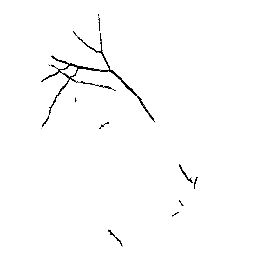

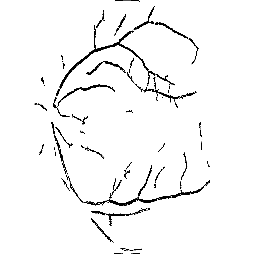

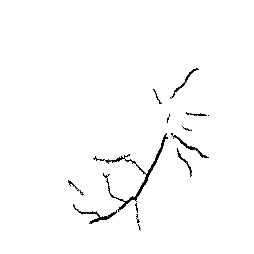

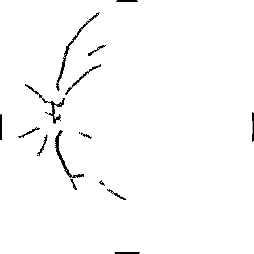

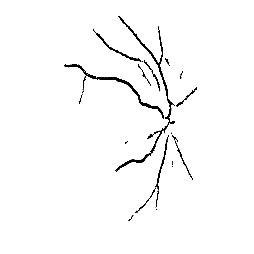

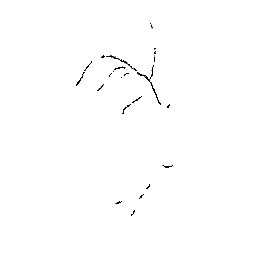

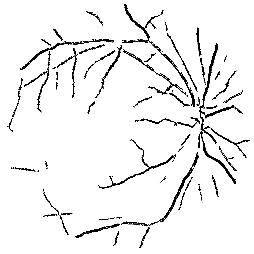

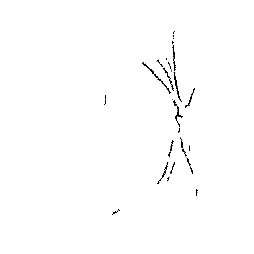

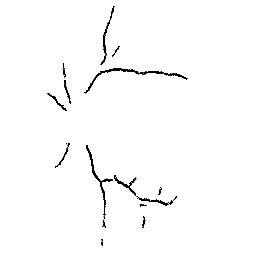

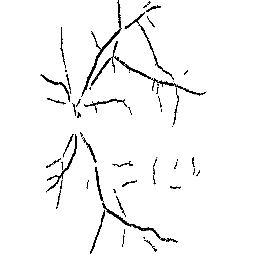

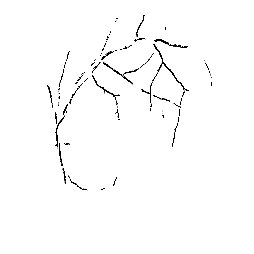

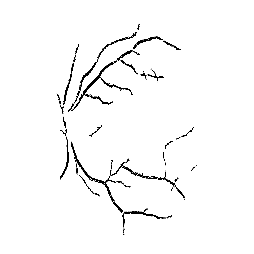

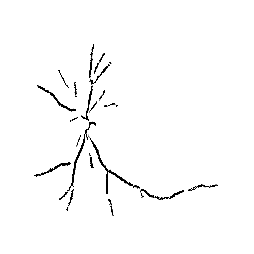

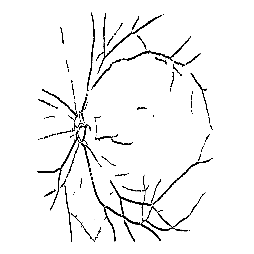

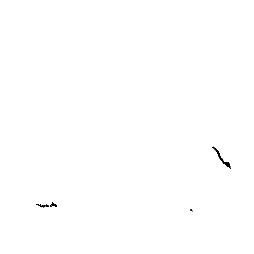

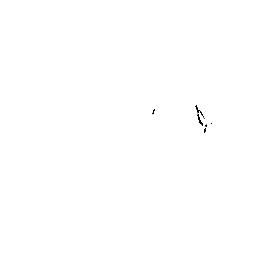

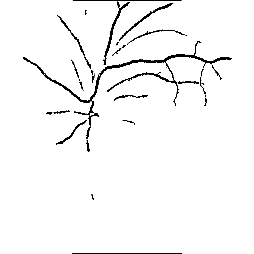

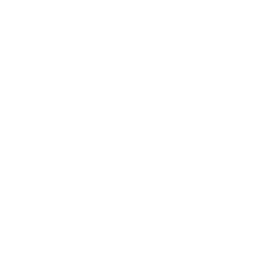

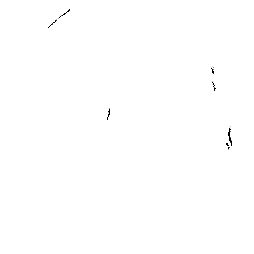

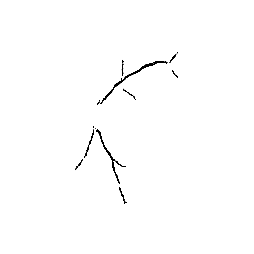

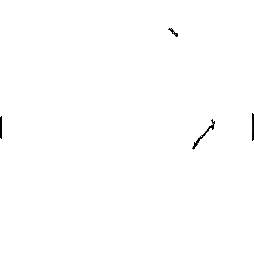

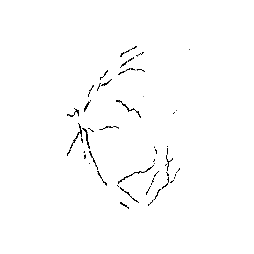

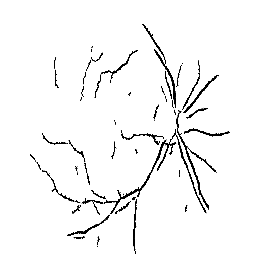

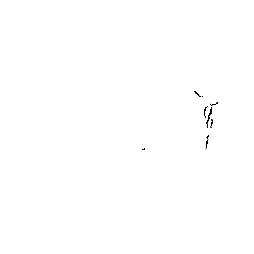

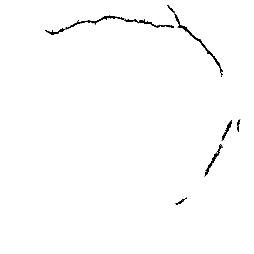

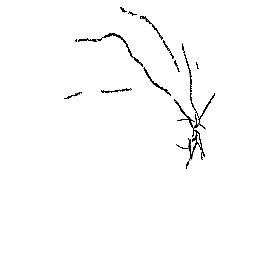

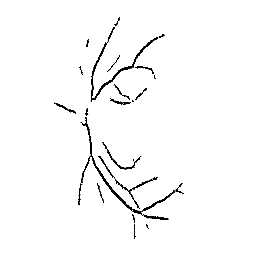

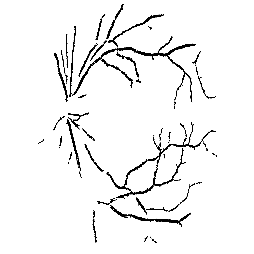

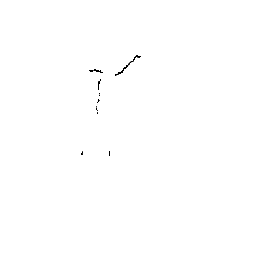

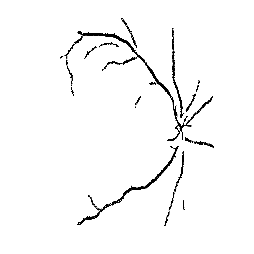

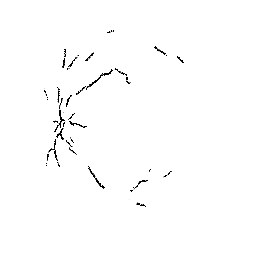

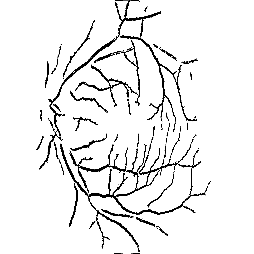

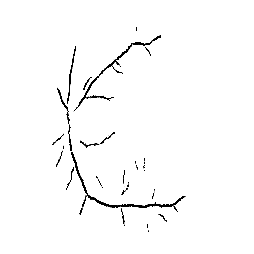

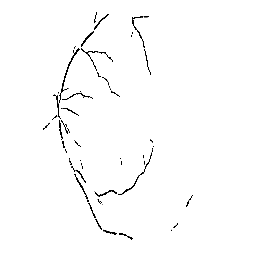

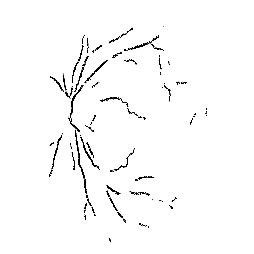

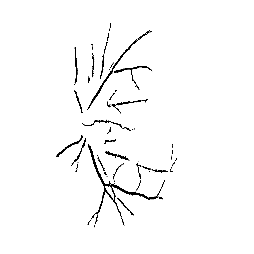

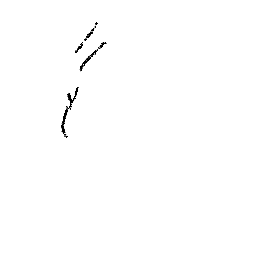

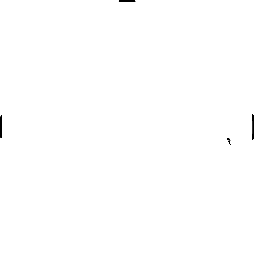

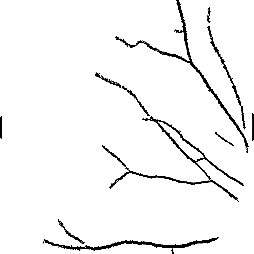

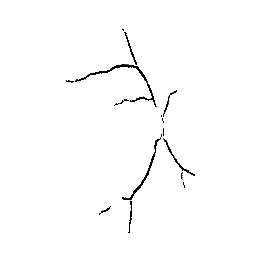

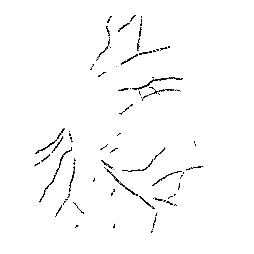

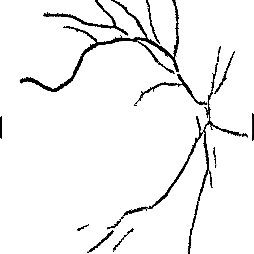

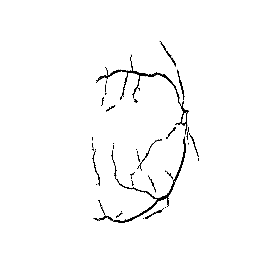

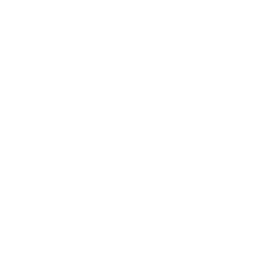

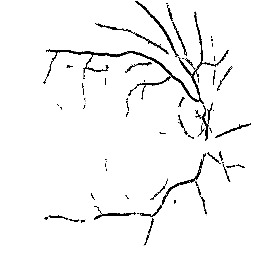

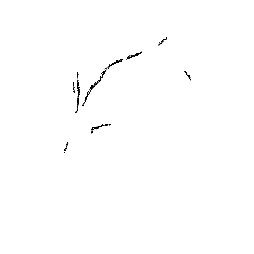

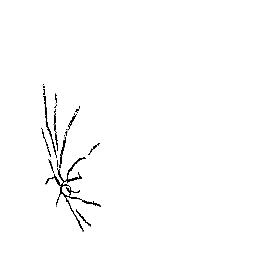

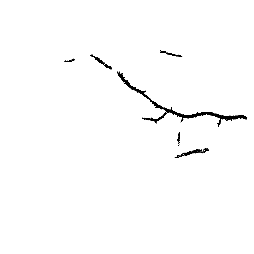

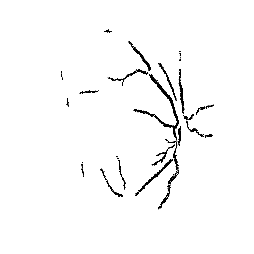

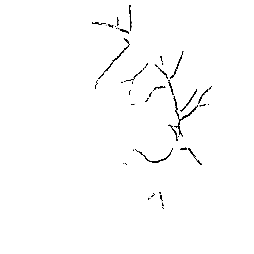

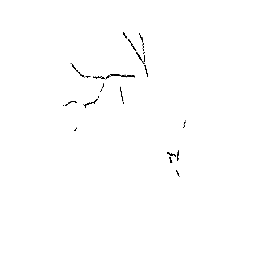

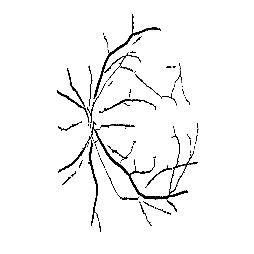

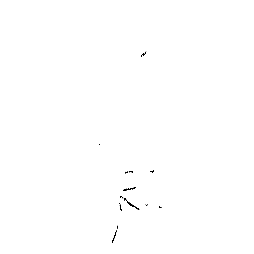

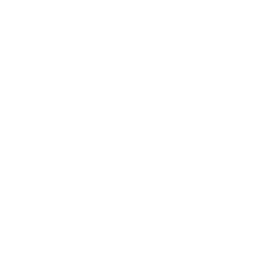

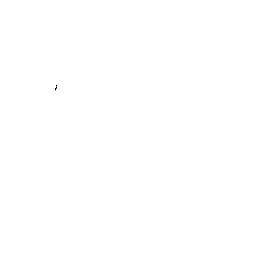

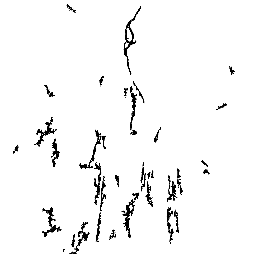

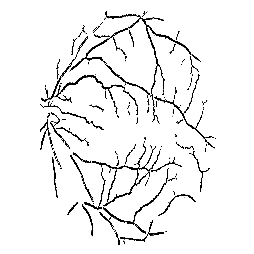

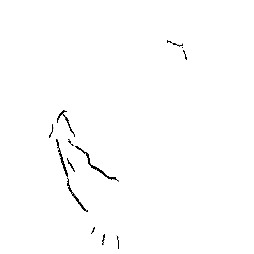

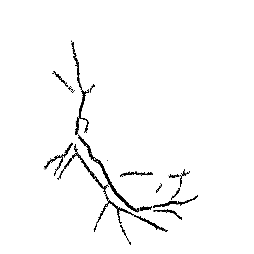

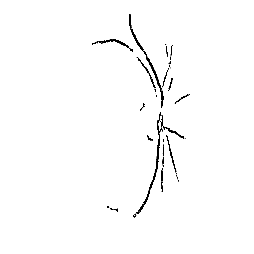

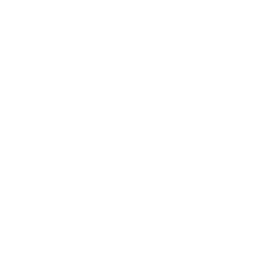

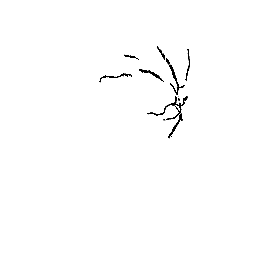

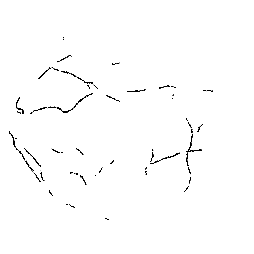

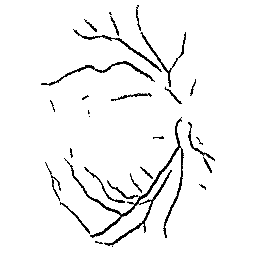

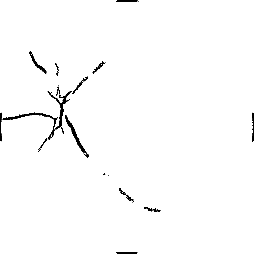

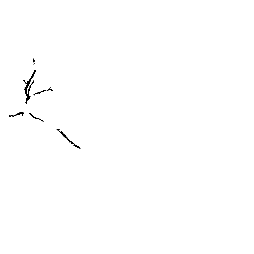

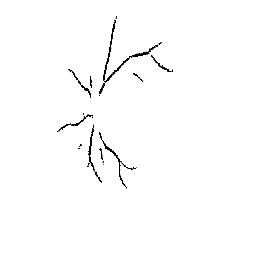

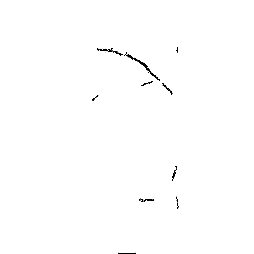

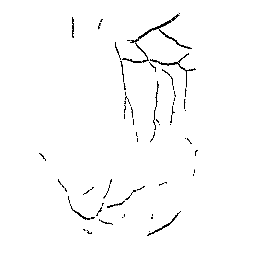

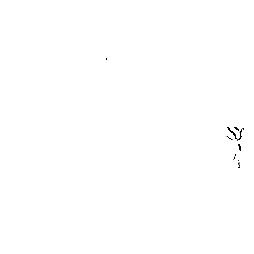

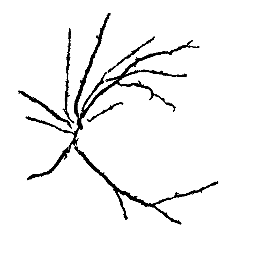

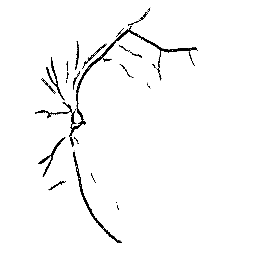

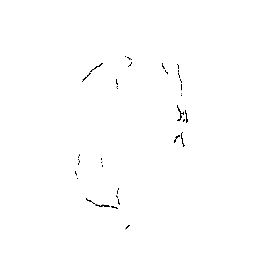

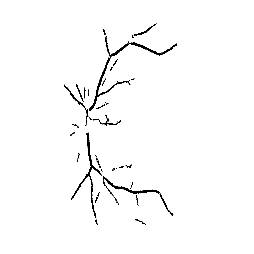

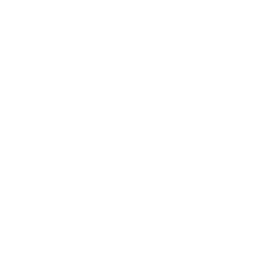

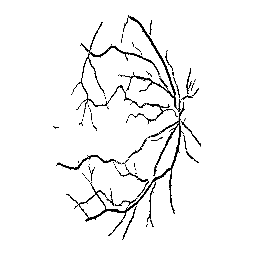

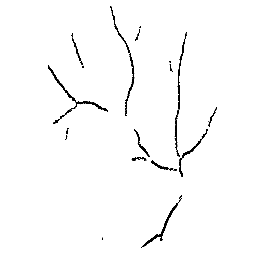

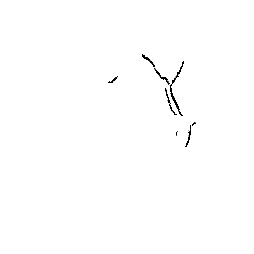

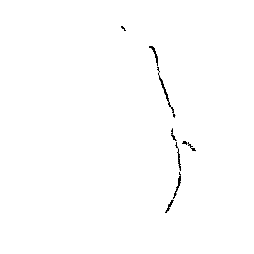

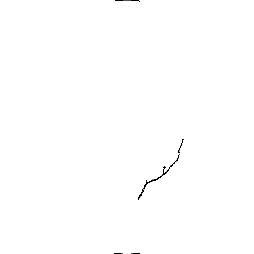

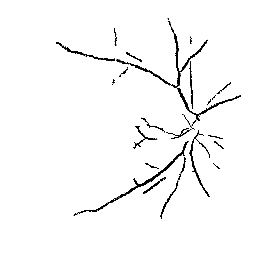

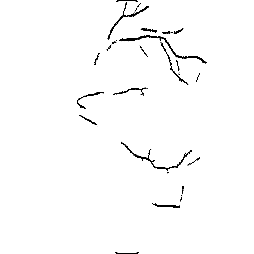

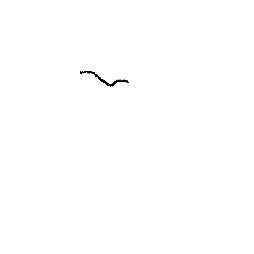

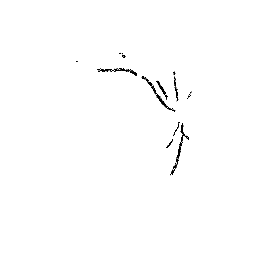

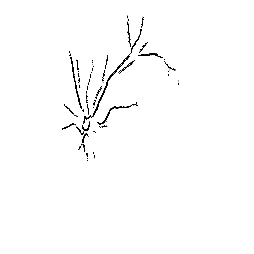

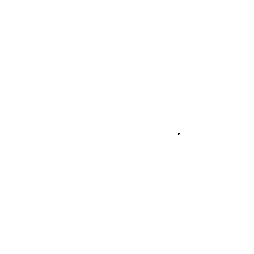

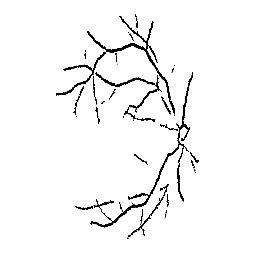

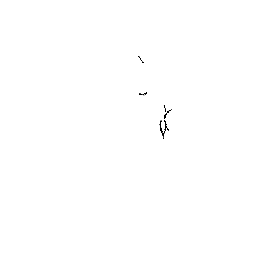

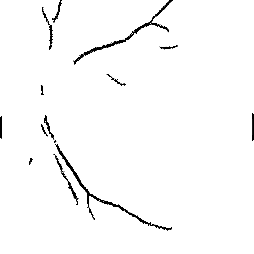

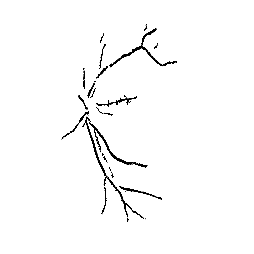

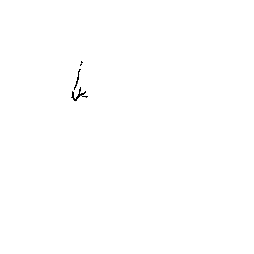

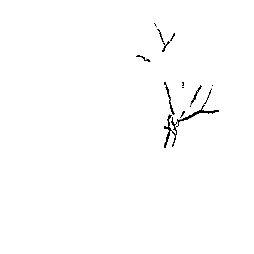

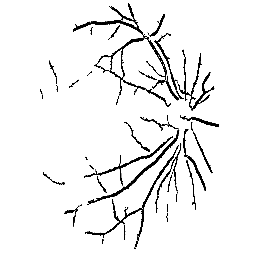

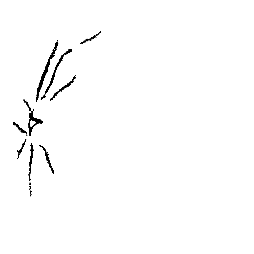

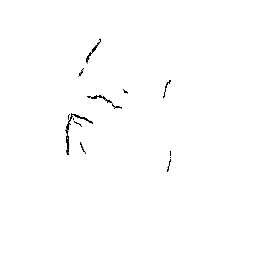

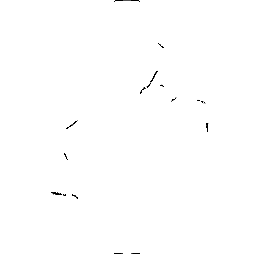

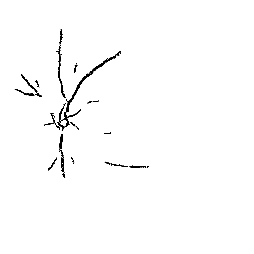

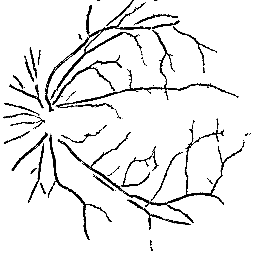

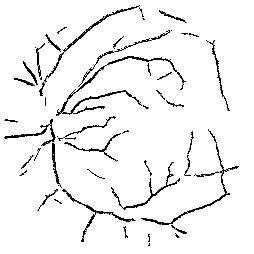

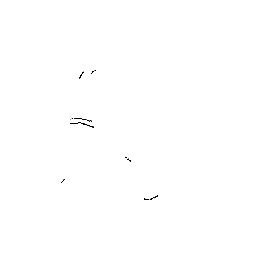

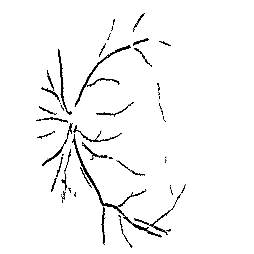

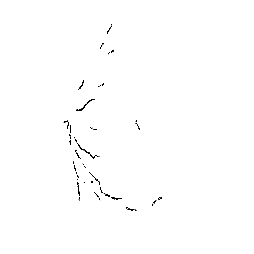

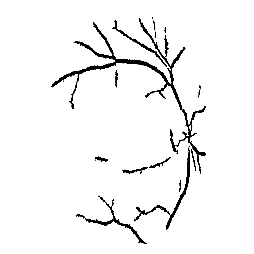

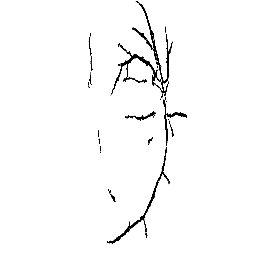

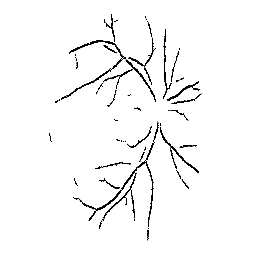

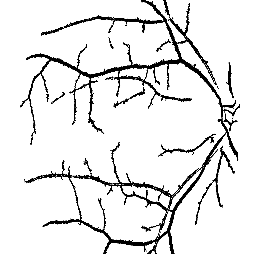

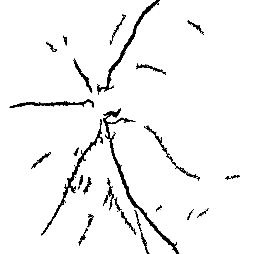

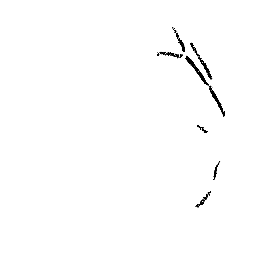

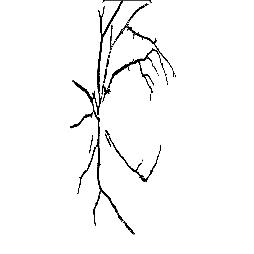

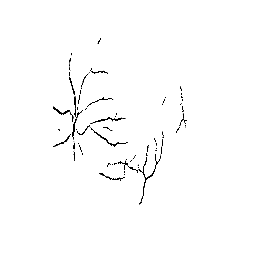

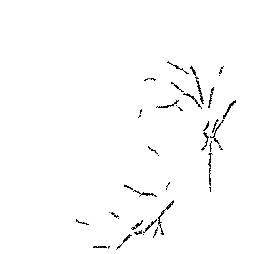

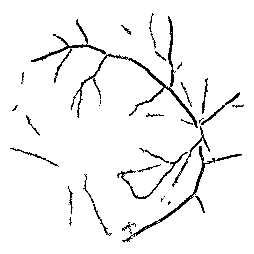

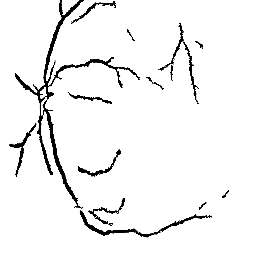

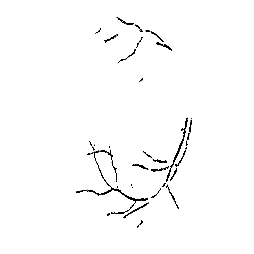

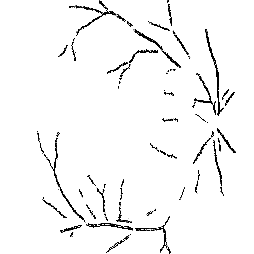

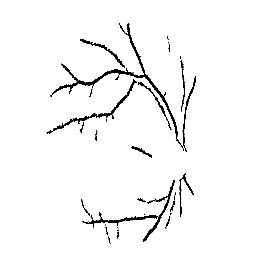

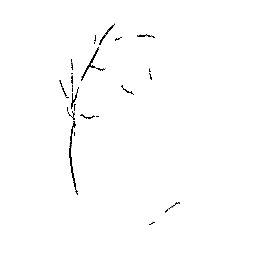

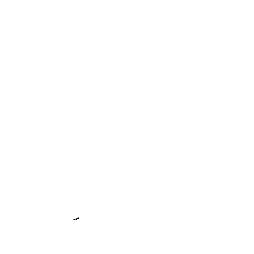

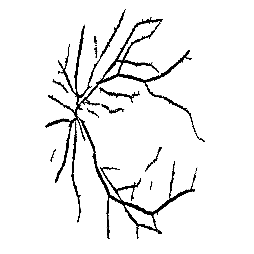

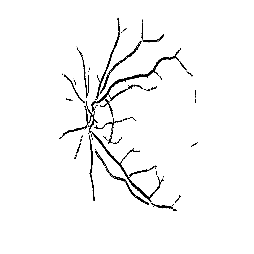

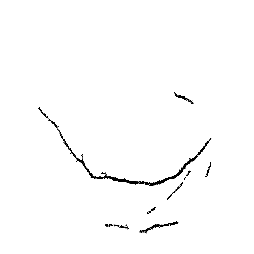

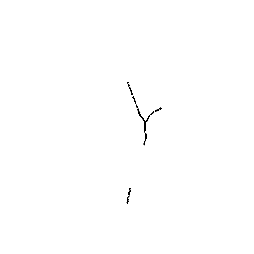

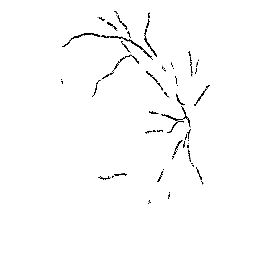

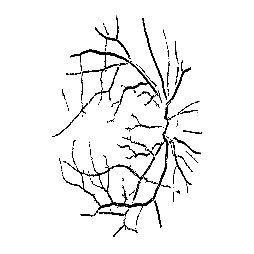

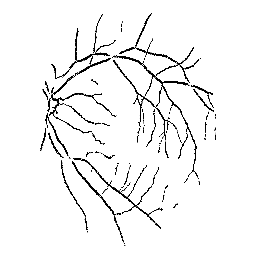

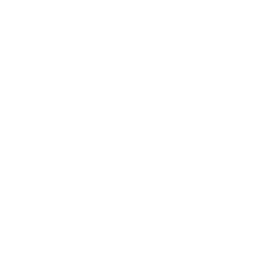

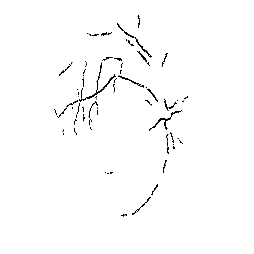

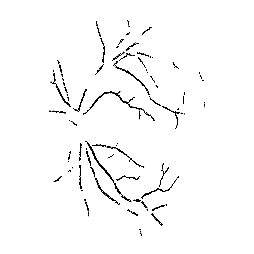

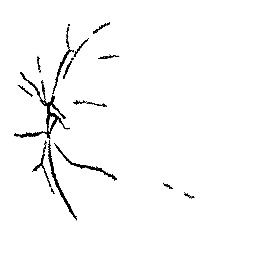

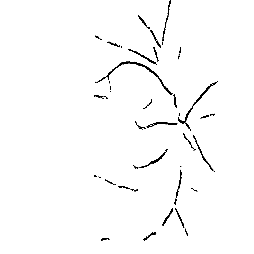

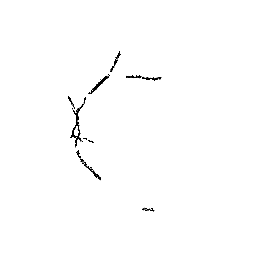

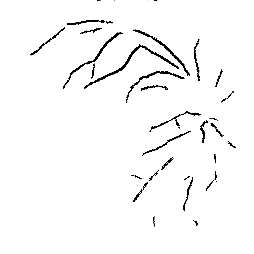

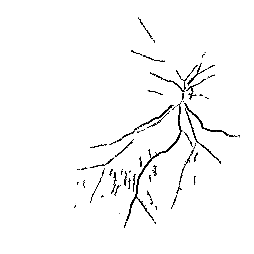

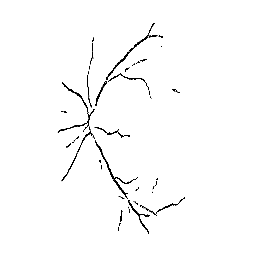

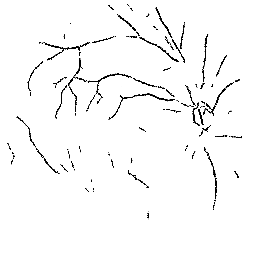

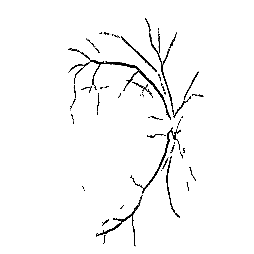

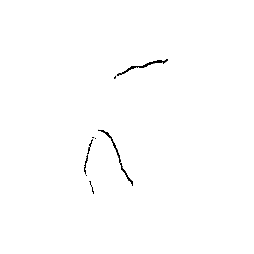

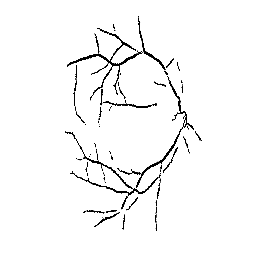

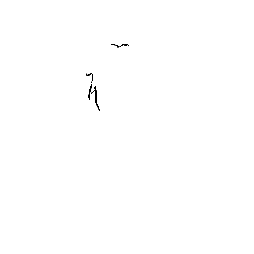

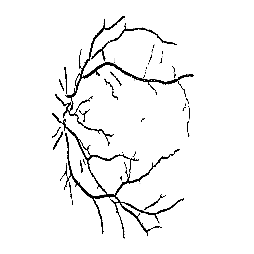

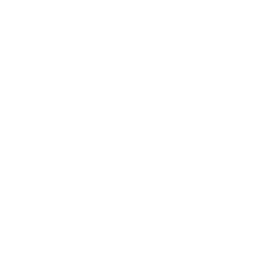

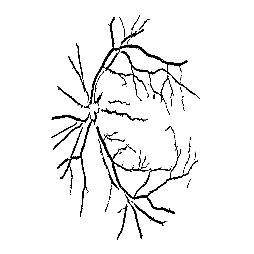

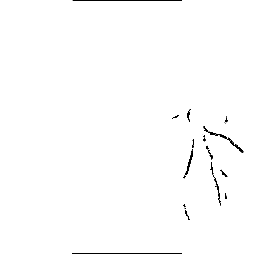

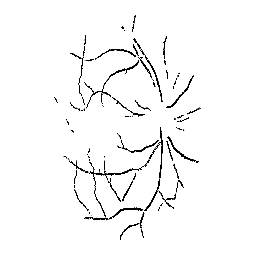

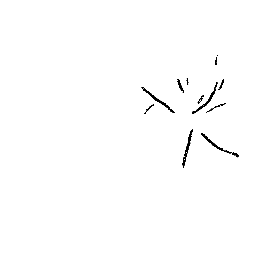

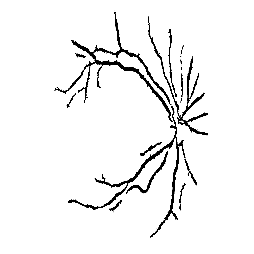

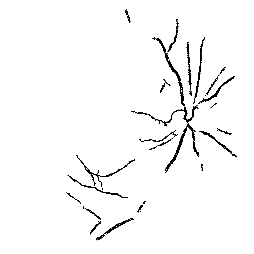

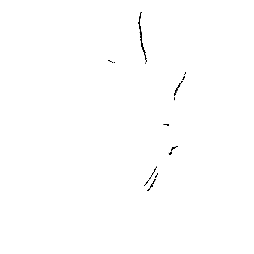

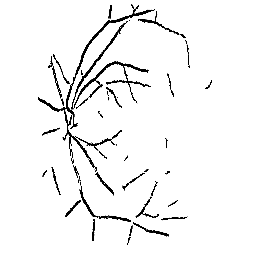

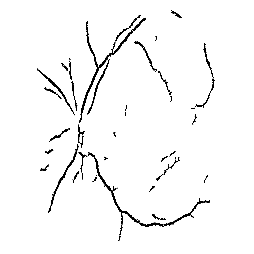

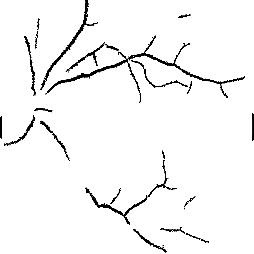

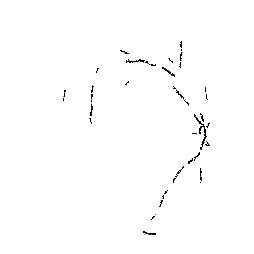

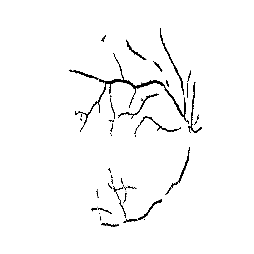

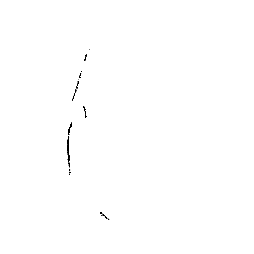

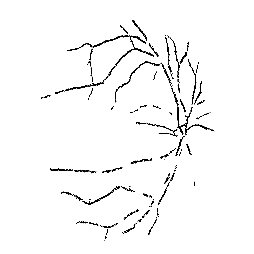

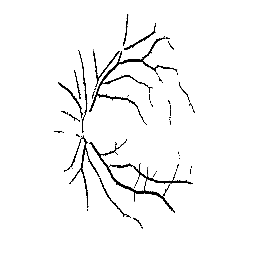

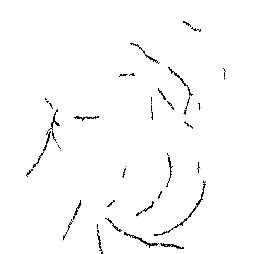

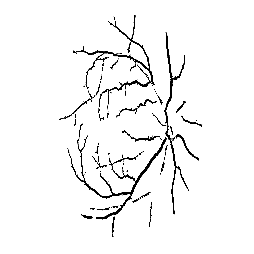

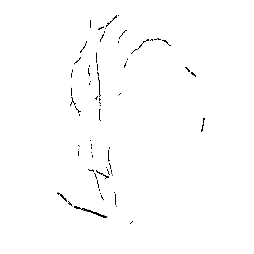

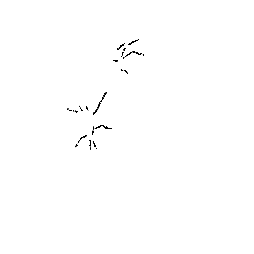

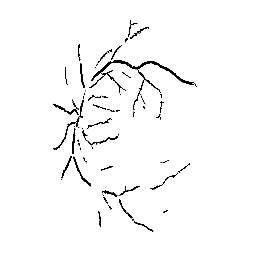

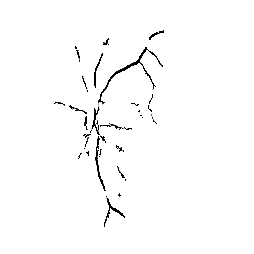

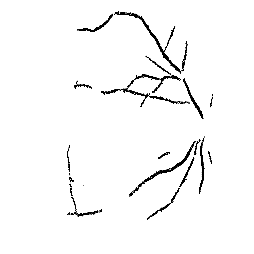

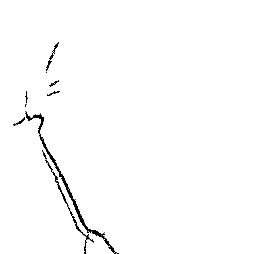

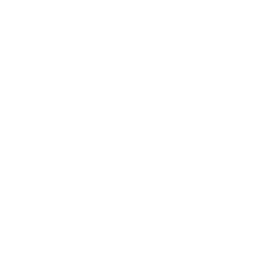

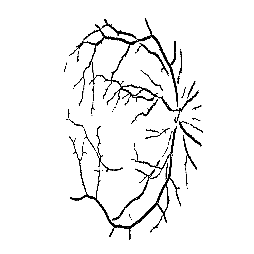

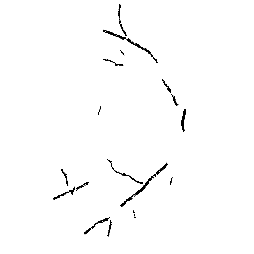

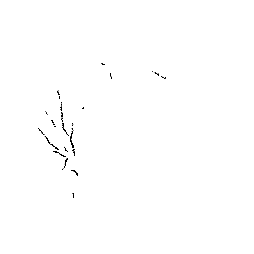

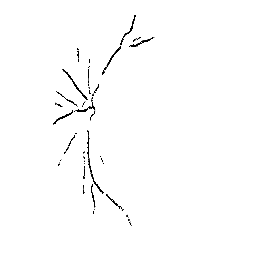

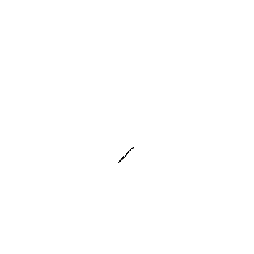

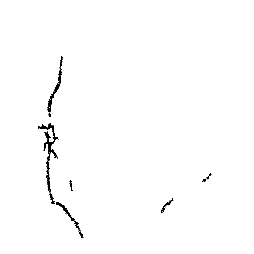

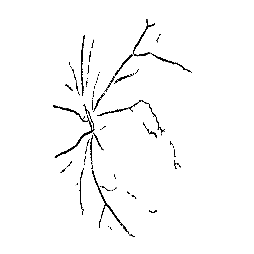

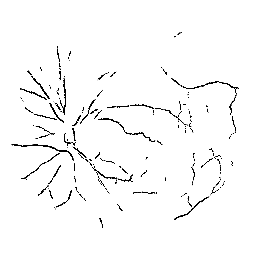

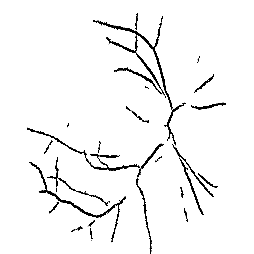

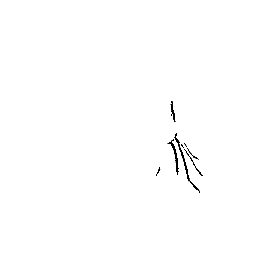

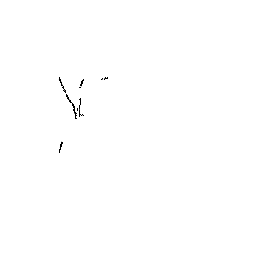

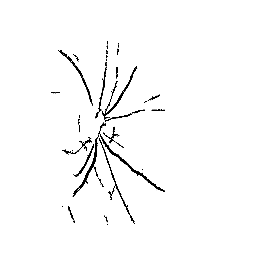

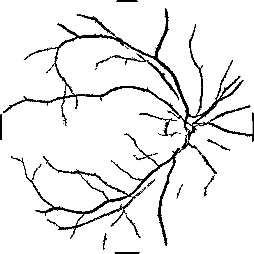

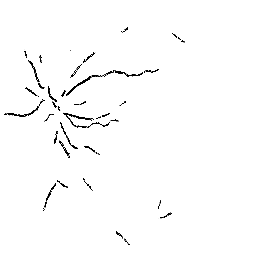

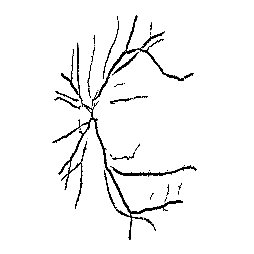

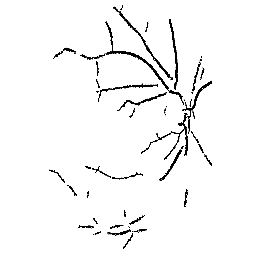

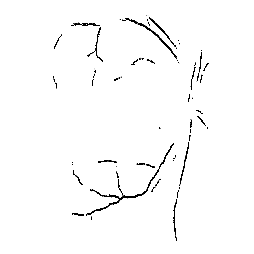

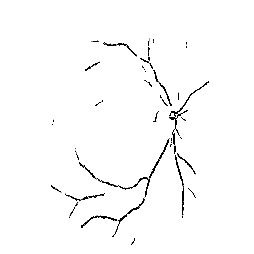

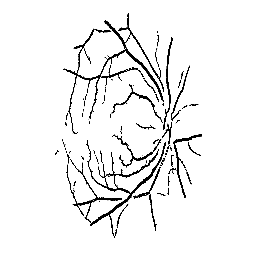

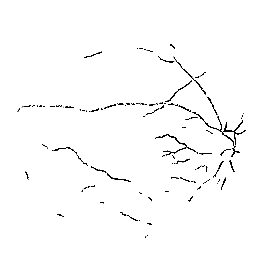

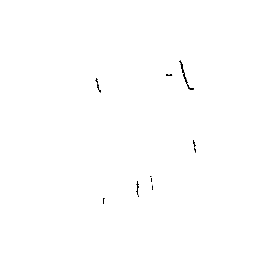

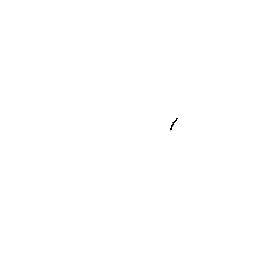

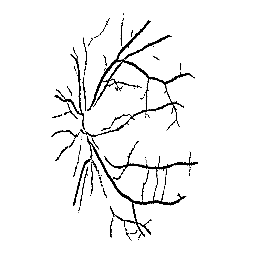

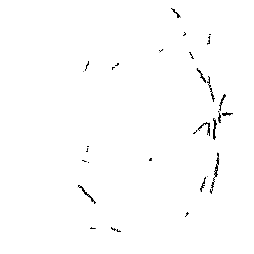

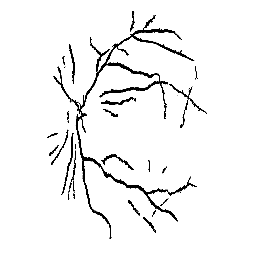

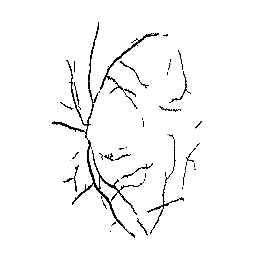

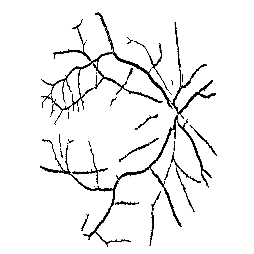

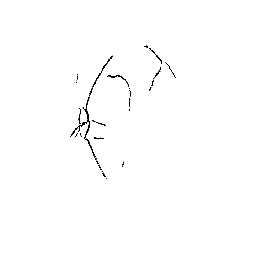

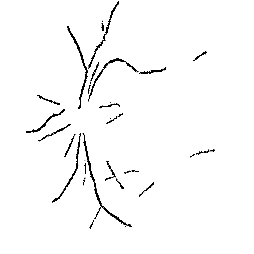

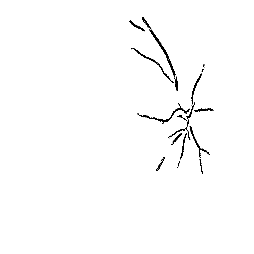

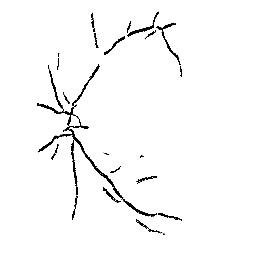

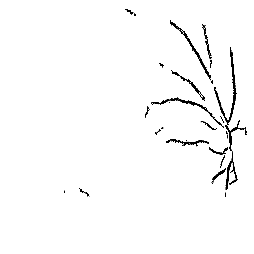

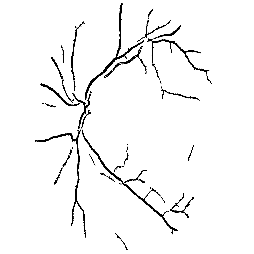

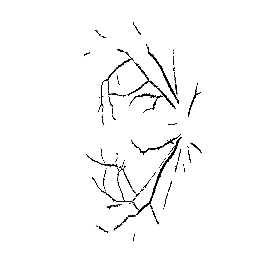

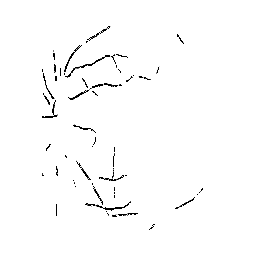

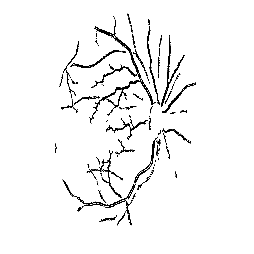

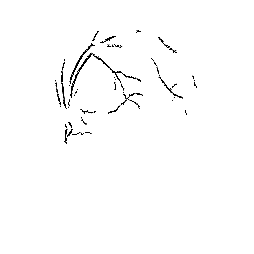

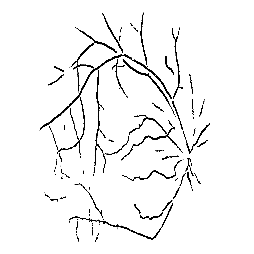

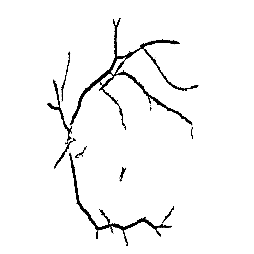

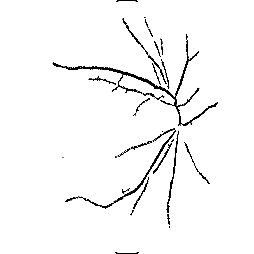

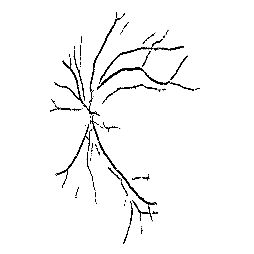

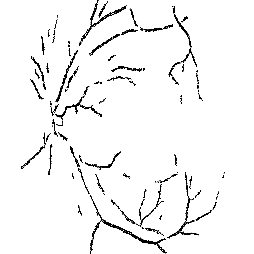

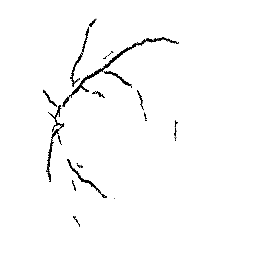

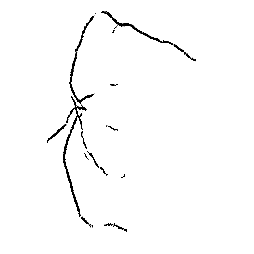

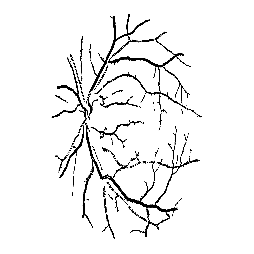

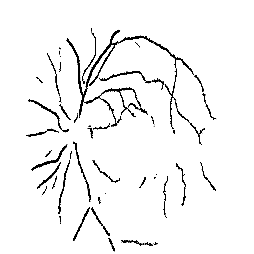

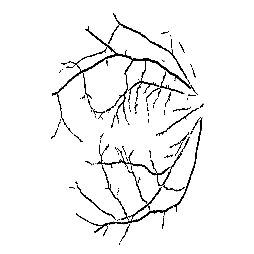

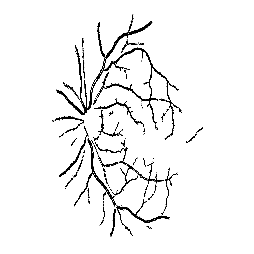

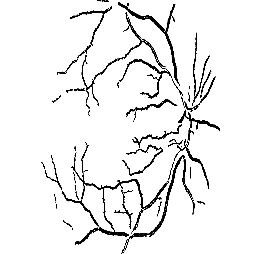

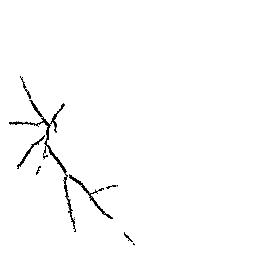

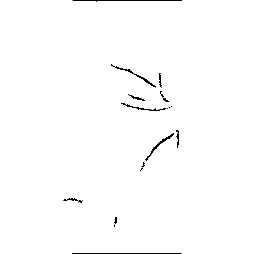

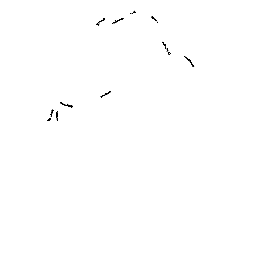

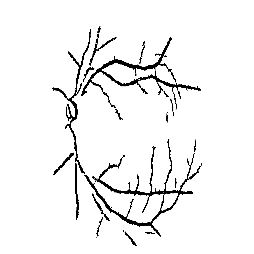

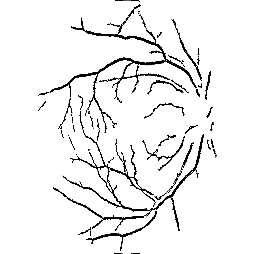

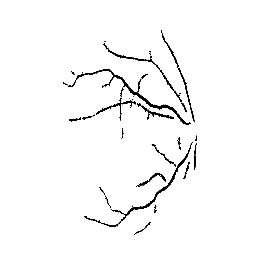

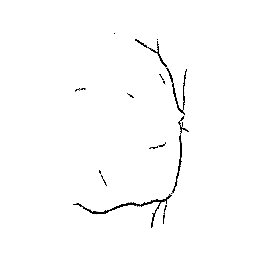

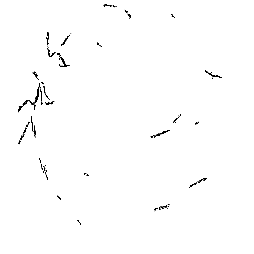

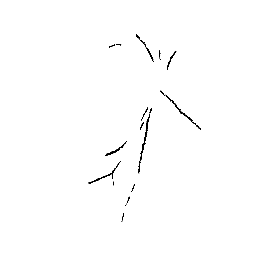

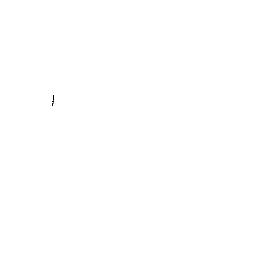

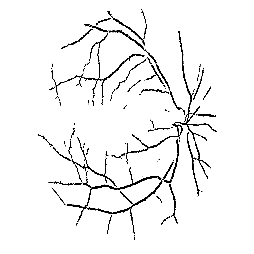

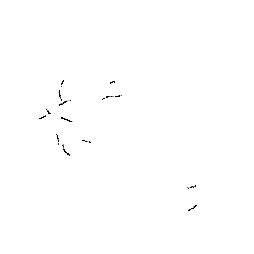

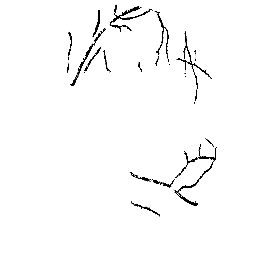

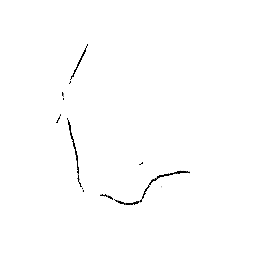

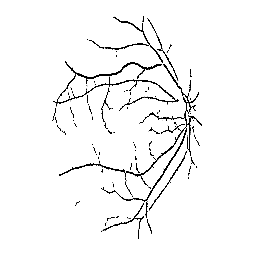

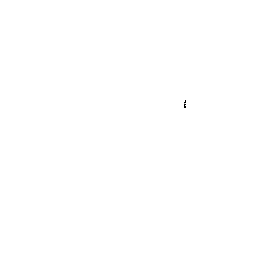

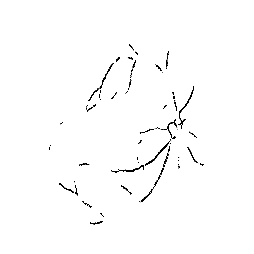

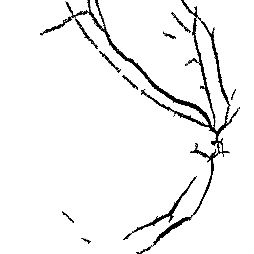

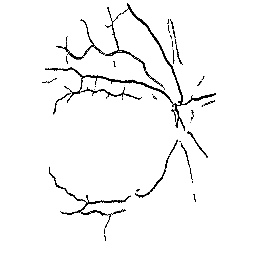

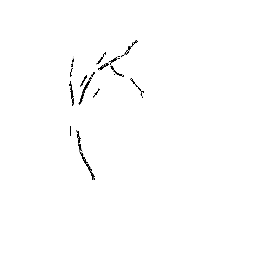

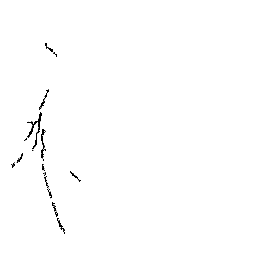

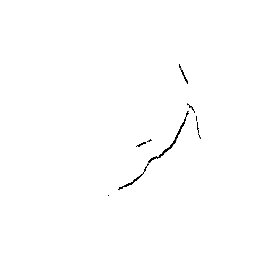

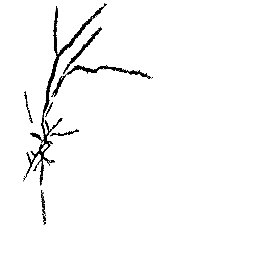

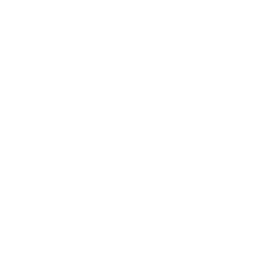

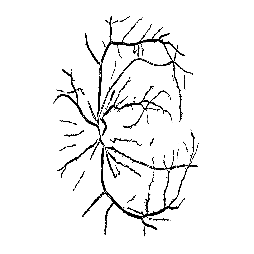

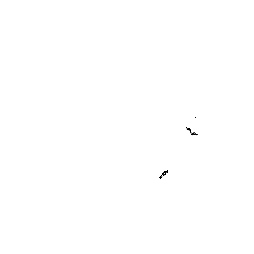

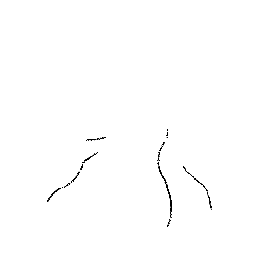

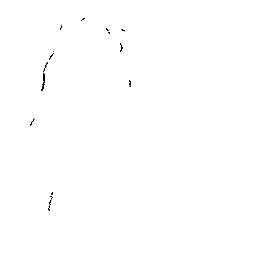

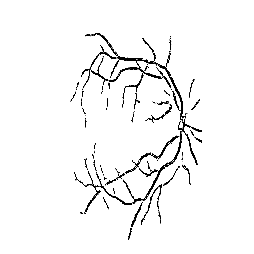

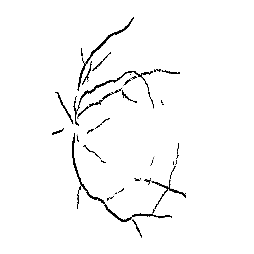

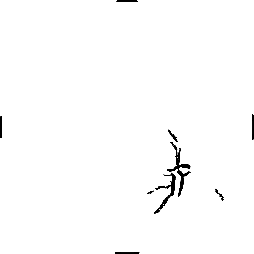

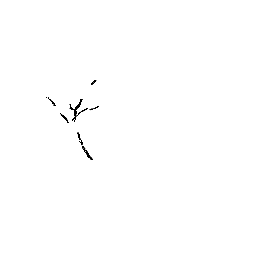

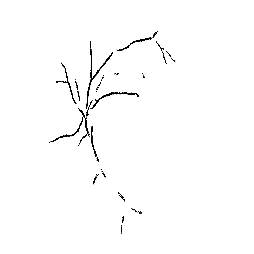

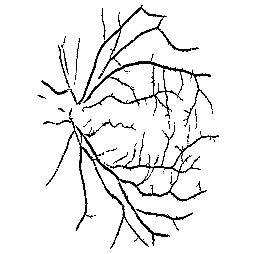

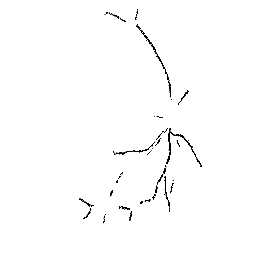

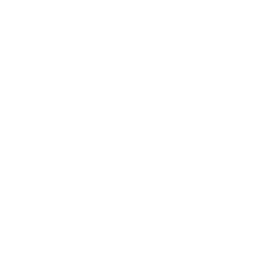

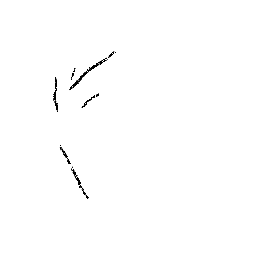

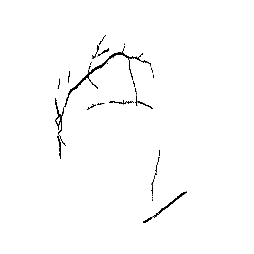

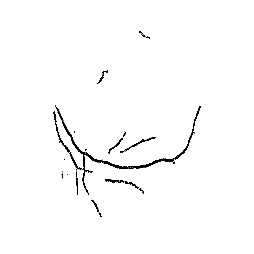

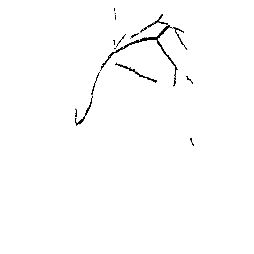

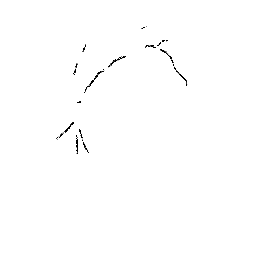

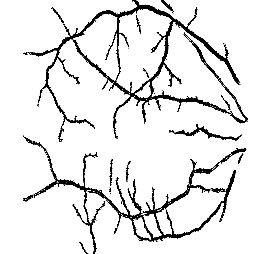

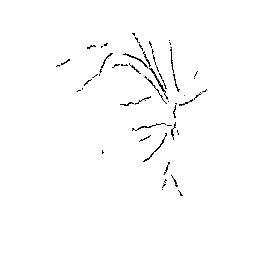

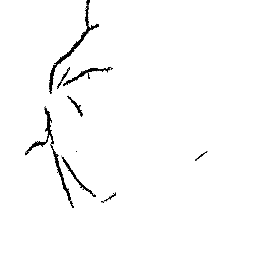

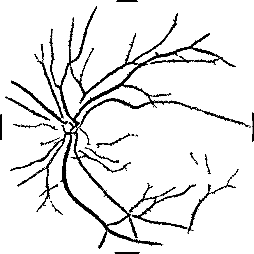

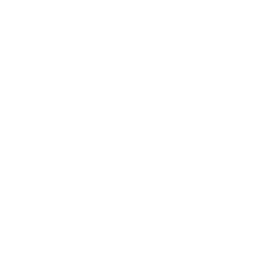

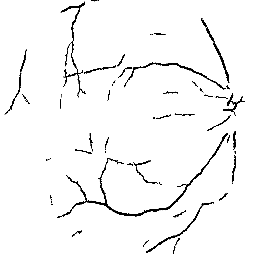

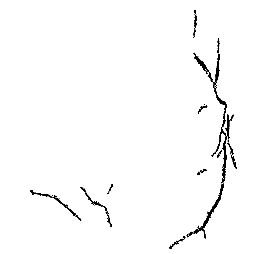

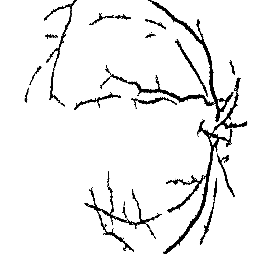

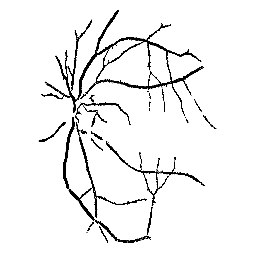

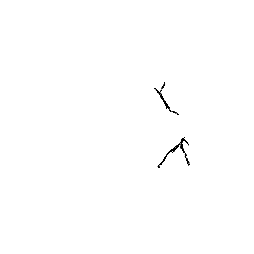

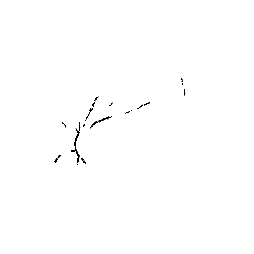

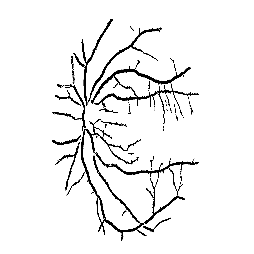

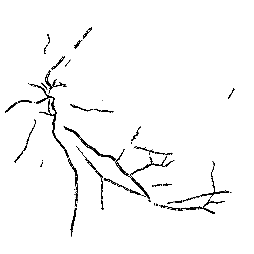

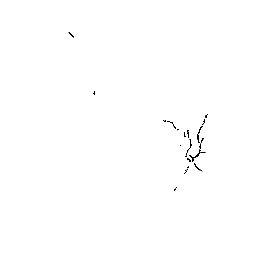

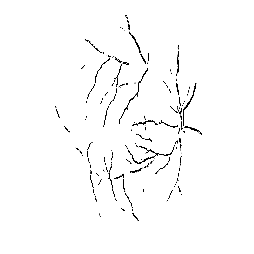

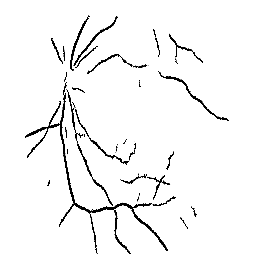

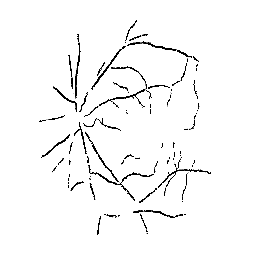

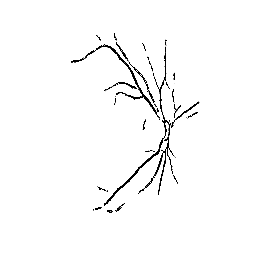

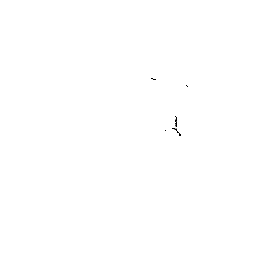

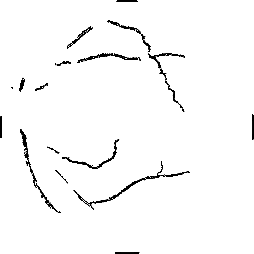

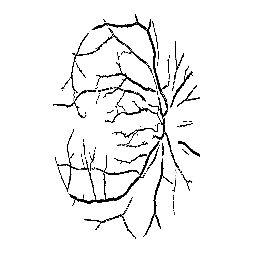

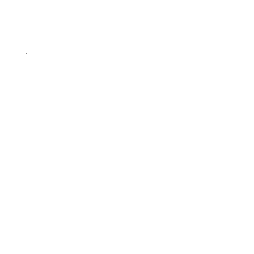

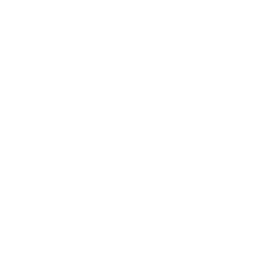

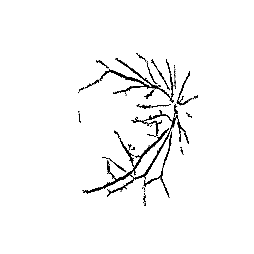

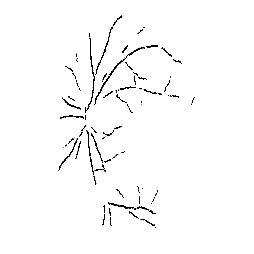

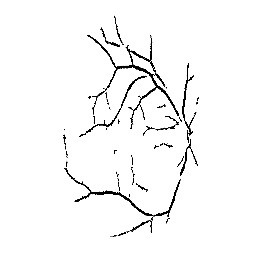

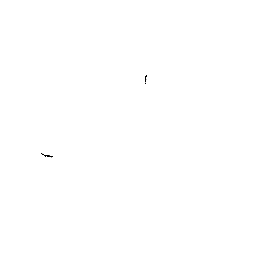

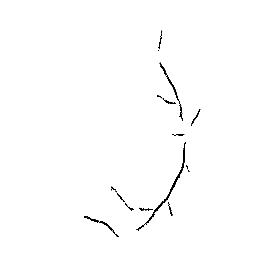

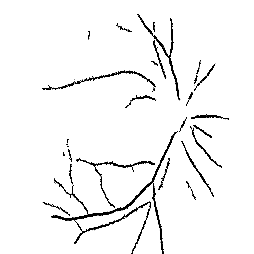

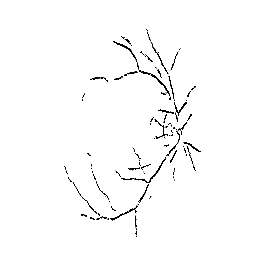

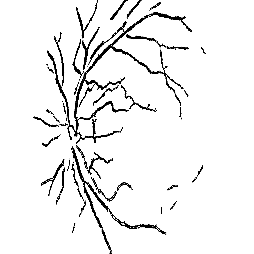

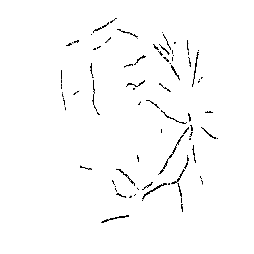

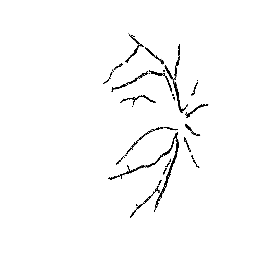

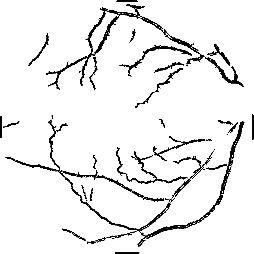

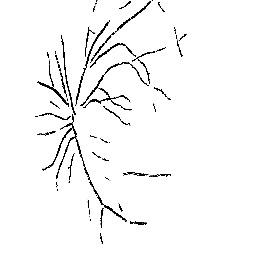

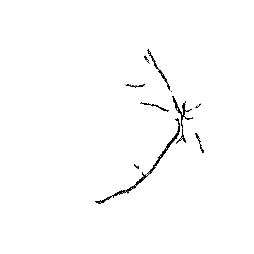

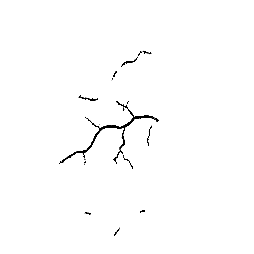

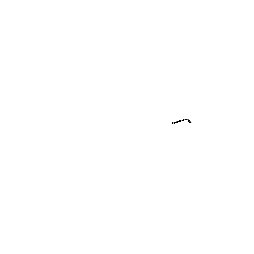

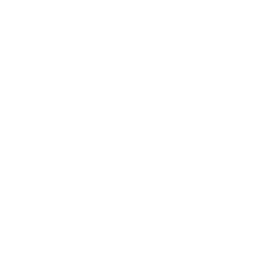

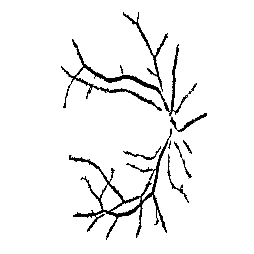

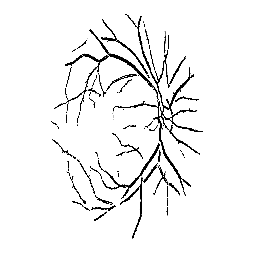

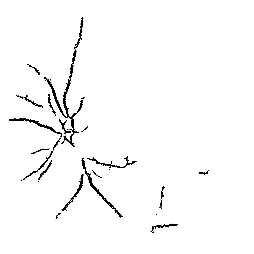

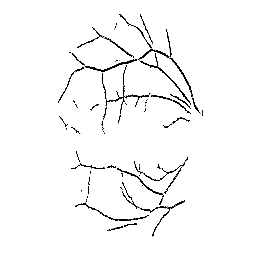

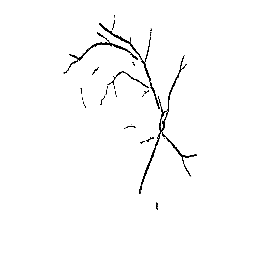

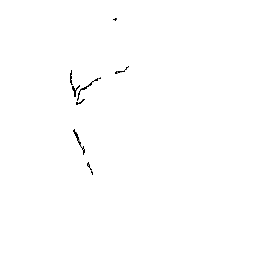

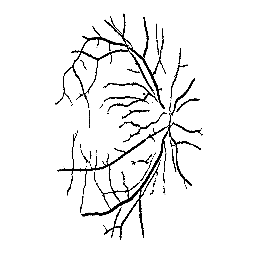

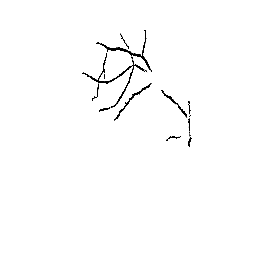

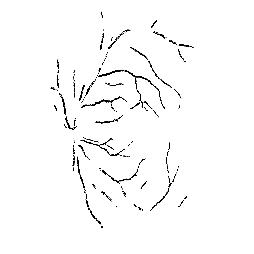

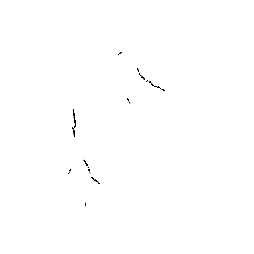

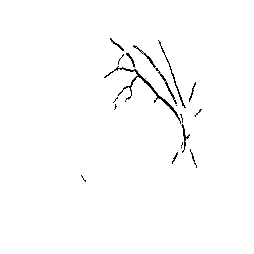

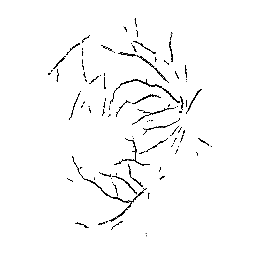

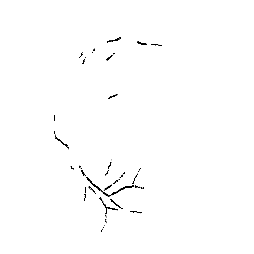

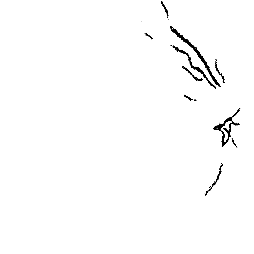

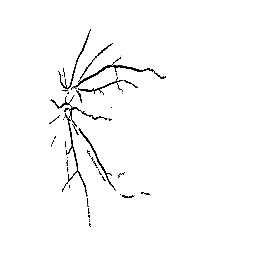

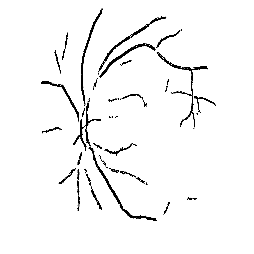

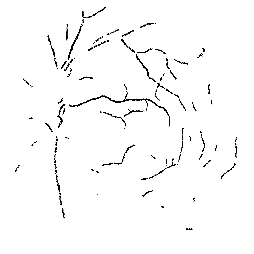

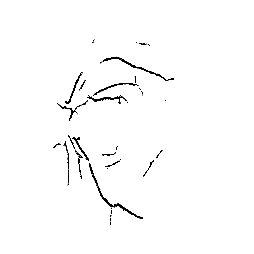

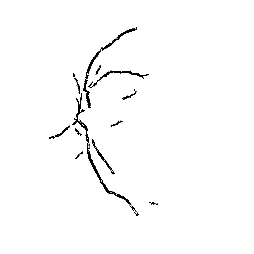

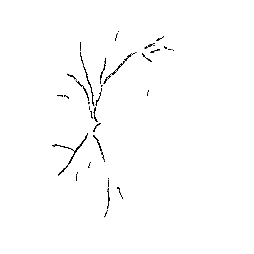

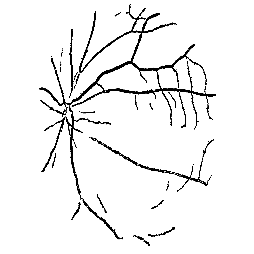

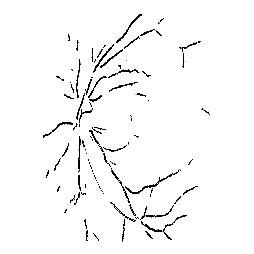

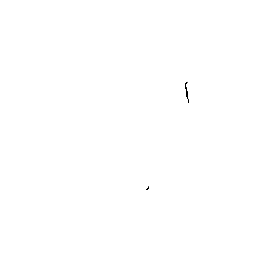

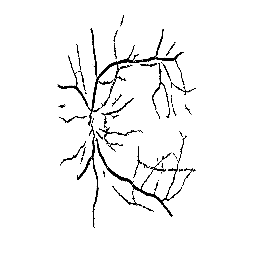

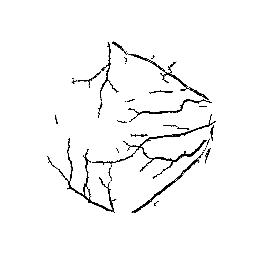

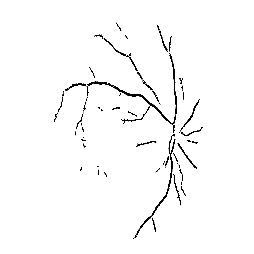

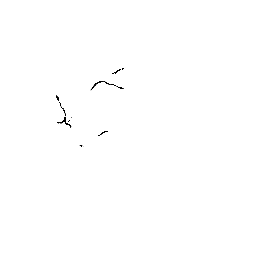

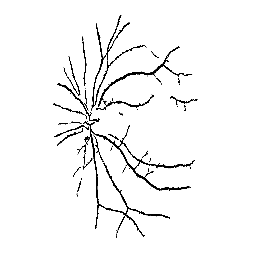

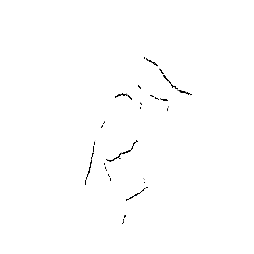

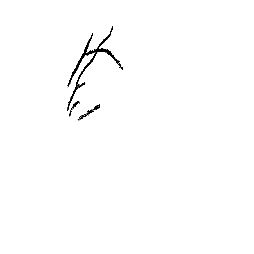

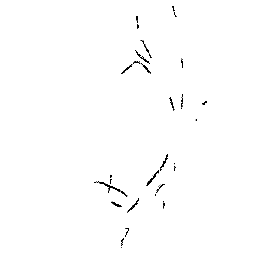

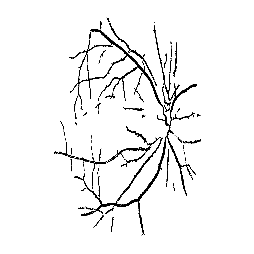

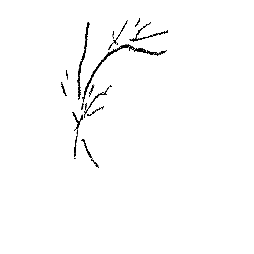

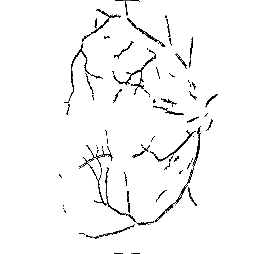

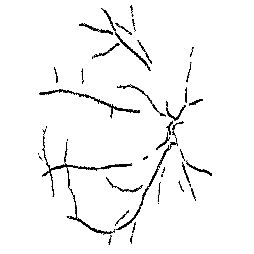

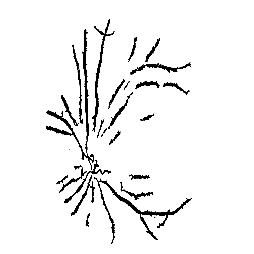

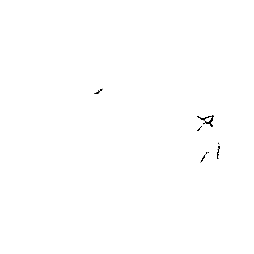

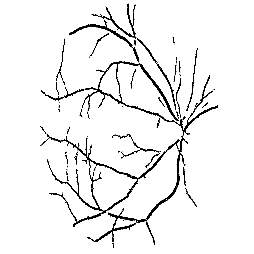

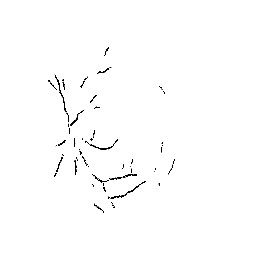

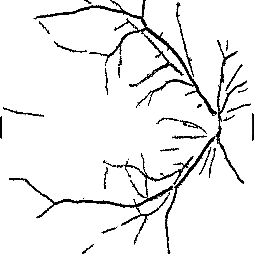

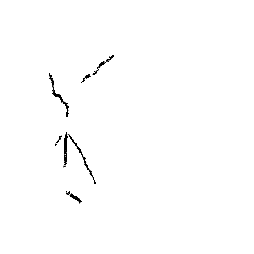

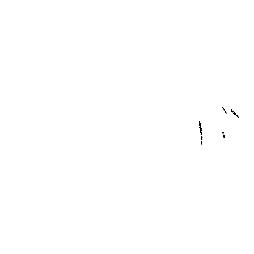

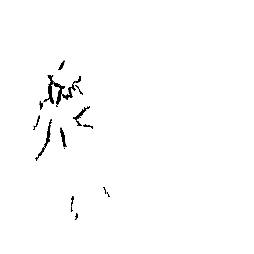

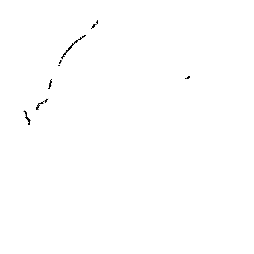

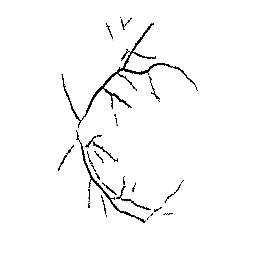

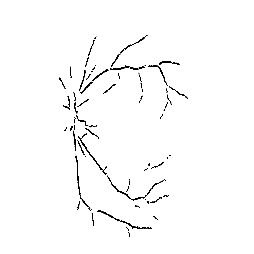

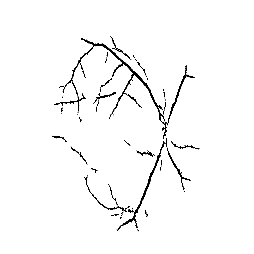

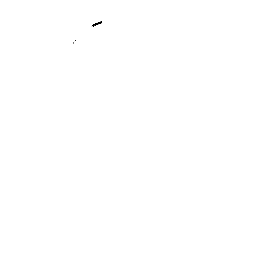

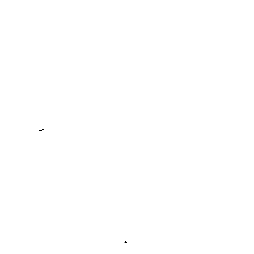

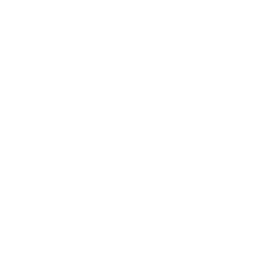

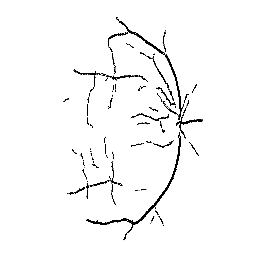

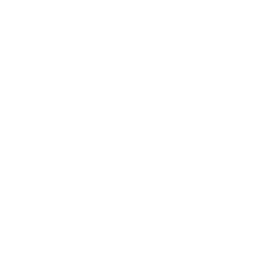

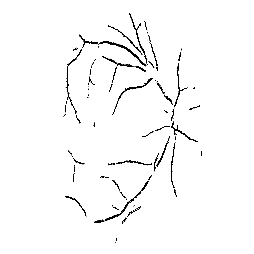

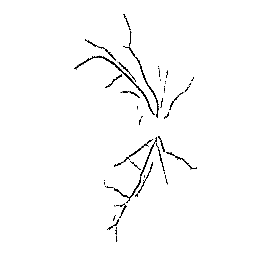

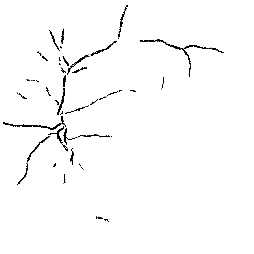

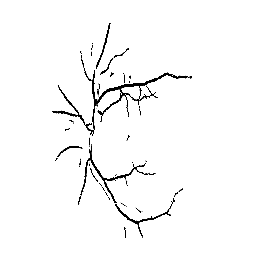

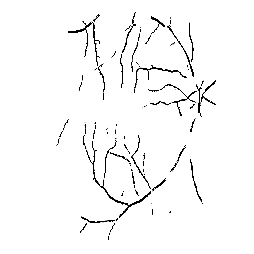

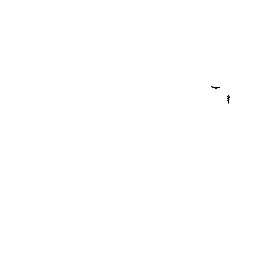

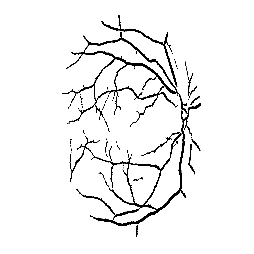

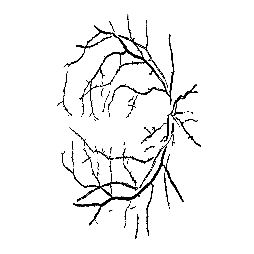

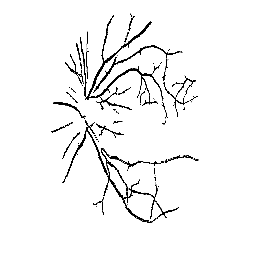

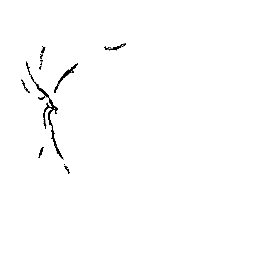

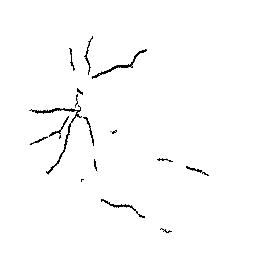

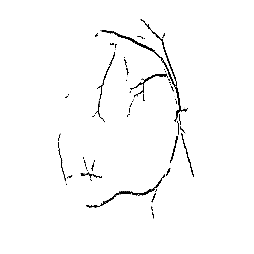

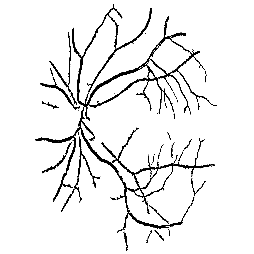

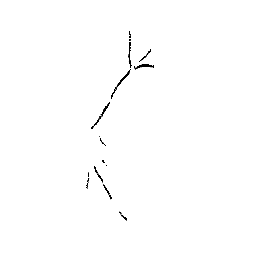

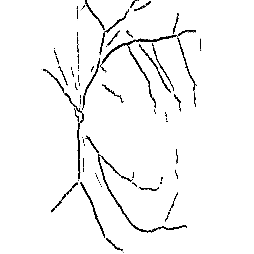

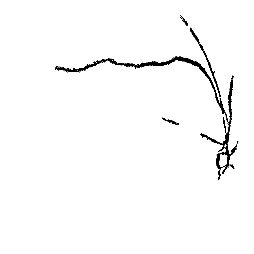

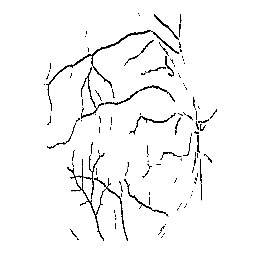

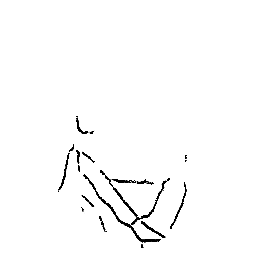

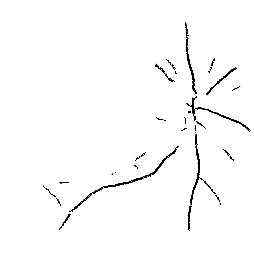

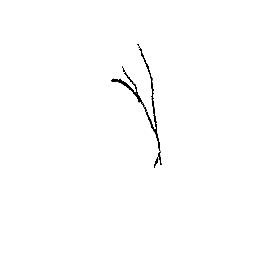

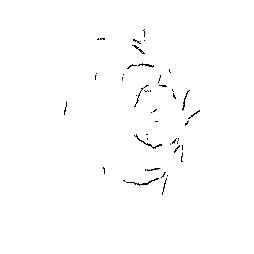

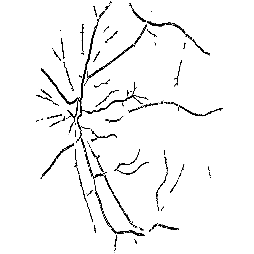

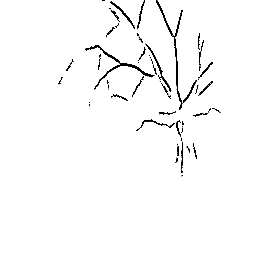

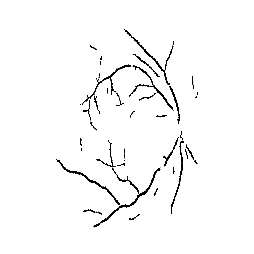

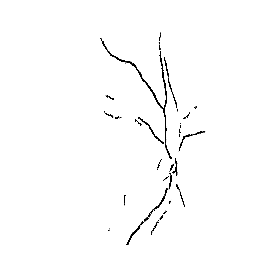

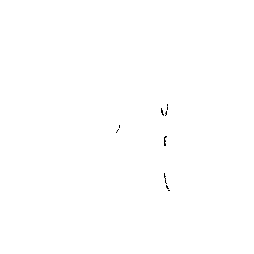

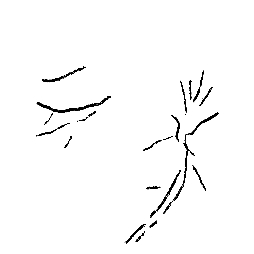

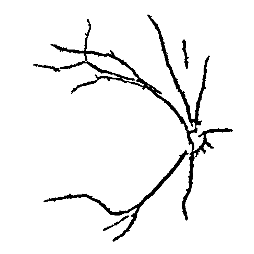

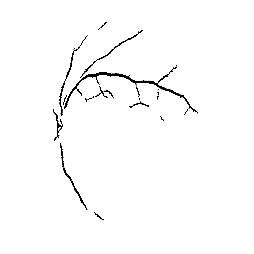

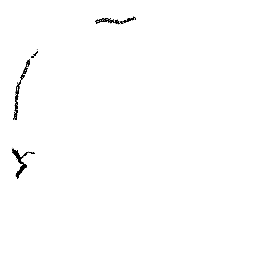

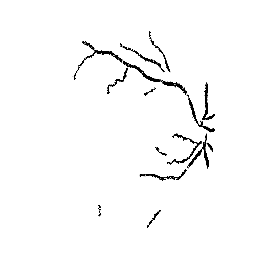

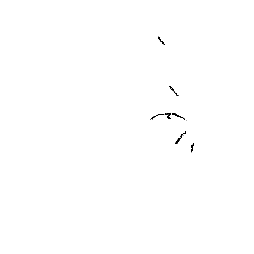

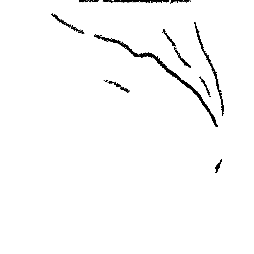

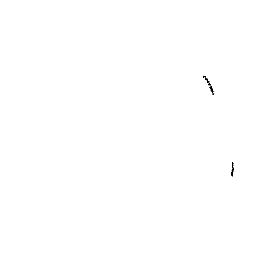

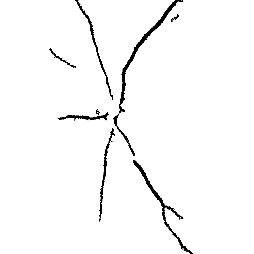

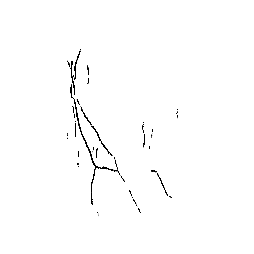

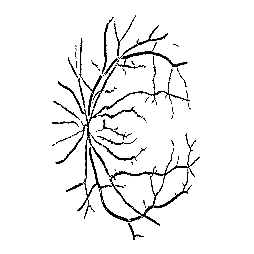

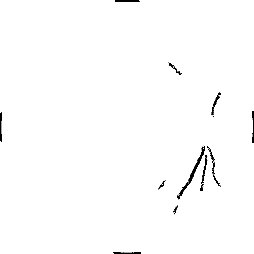

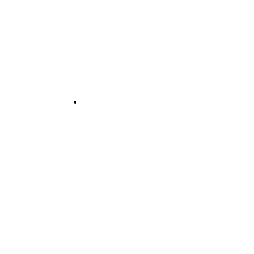

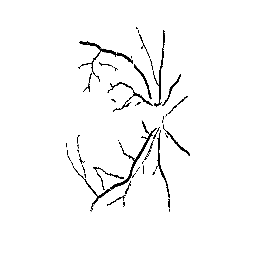

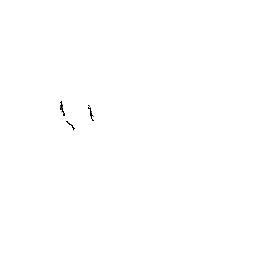

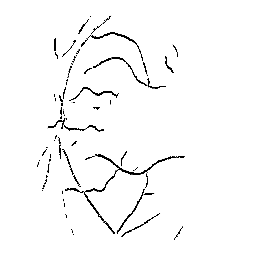

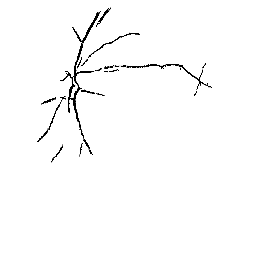

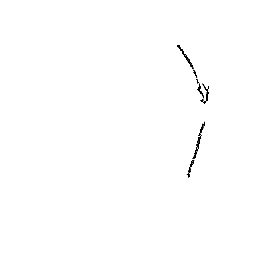

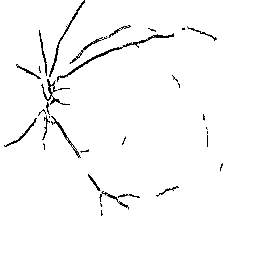

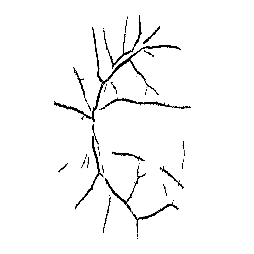

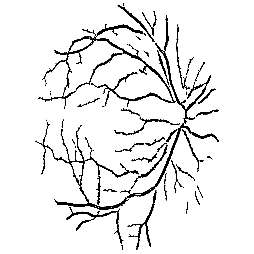

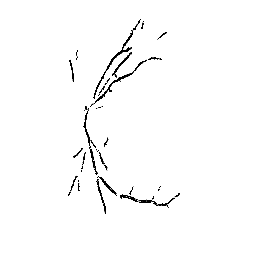

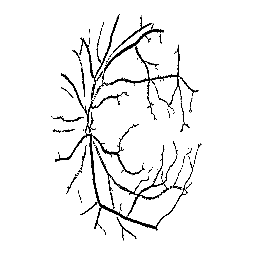

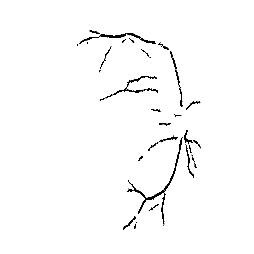

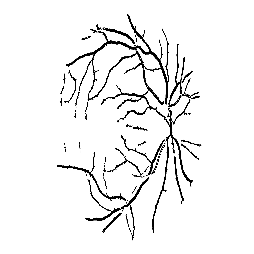

In [ ]:
BASEPATH = 'database/'
classes = ['0','1']


if (not os.path.exists('processed')):
  os.mkdir('processed')
  os.mkdir('processed/0')
  os.mkdir('processed/1')

# transform = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1,p=1.0 ),
# ])
transform = A.Compose([
                      #  A.augmentations.transforms.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
                       A.augmentations.transforms.RandomBrightness(limit=(-0.9,0.9), p=0.7),
                       A.augmentations.transforms.RandomContrast (limit=(-0.8,0.9), p=0.7),
                       A.augmentations.transforms.Flip((-1.0,1.0),p=1.0), 
                       A.OneOf([
                                A.HorizontalFlip(p=1.0),
                                A.VerticalFlip(p=1.0),
                                ],p=0.7)
                       ])
count = 0
for f in classes:
  path = glob.glob(BASEPATH + f + '/*' + '.jpg', recursive=True)
  for img in path:
    filename = img.replace('database/'+f+'/','')

    if (f=='0'): #salvando as imagens NORMAIS em processed, sem usar o blood vessel
      
      ## Salvando arquivos processados sem a Blood Vessel
      path_to_save = 'processed/' + f + '/' + str(filename)
      
      originalImage = cv2.imread(img)
      image = pre_processing(originalImage, False)

      cv2.imwrite(path_to_save, image)

    elif (f=='1'): #salvando as imagens de GLAUCOMA em processed
      originalImage = cv2.imread(img)

      path_to_save = 'processed/' + f + '/'
      image = pre_processing(originalImage)

      transformed_image_1 = transform(image=image)['image']
      trans_filename1 = 'trasf_1_' + str(filename)

      transformed_image_2 = transform(image=image)['image']
      trans_filename2 = 'trasf_2_' + str(filename)
      
      transformed_image_3 = transform(image=image)['image']
      trans_filename3 = 'trasf_3_' + str(filename)
      
      transformed_image_4 = transform(image=image)['image']
      trans_filename4 = 'trasf_4_' + str(filename)

      cv2.imwrite(path_to_save + str(img), image)
      cv2.imwrite(path_to_save + trans_filename1 , transformed_image_1)
      cv2.imwrite(path_to_save + trans_filename2, transformed_image_2)
      cv2.imwrite(path_to_save + trans_filename3, transformed_image_3)
      cv2.imwrite(path_to_save + trans_filename4, transformed_image_4)

      # # - - - - - - DEPURAÇÃO - - - - - - - - - #
      # count+=1
      # cv2_imshow(image)
      # print("O R I G I N A L - Processed")     
      # cv2_imshow(transformed_image_1)
      # cv2_imshow(transformed_image_2)
      # cv2_imshow(transformed_image_3)
      # cv2_imshow(transformed_image_4)
      # print("=================================================================")
      # if (count >50):
      #   break




In [ ]:
print("DATABASE ORIGINAL")
print("0:", end=" ")
!ls /content/database/0 | wc -l
print("1:", end=" ")
!ls /content/database/1 | wc -l

print("DATABASE PROCESSADO")
print("0:", end=" ")
!ls /content/processed/0 | wc -l
print("1:", end=" ")
!ls /content/processed/1 | wc -l

DATABASE ORIGINAL
0: 2101
1: 397
DATABASE PROCESSADO
0: 2101
1: 1588


# **Dividindo a base de dados**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2
from copy import deepcopy
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as n
# from keras import utils

#Batch Generator
# from imblearn.under_sampling import NearMiss
from imblearn.tensorflow import balanced_batch_generator

image_format = '.jpg'

base_folder='database'
base_folder_processed = 'processed'
img_height = 256
img_width = 256

batch_size = 16

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder,
    label_mode='categorical', #multiclass
    image_size=(img_height, img_width),
    batch_size = batch_size,
    subset='training',
    validation_split = 0.2,
    seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder,
    label_mode='categorical', #multiclass
    image_size=(img_height, img_width),
    batch_size = batch_size,
    subset='validation',
    validation_split = 0.2,
    seed=123
)

train_dataset_processed = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder_processed,
    label_mode='categorical', #multiclass
    image_size=(img_height, img_width),
    batch_size = batch_size,
    subset='training',
    validation_split = 0.2,
    seed=123
)

validation_dataset_processed = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder_processed,
    label_mode='categorical', #multiclass
    image_size=(img_height, img_width),
    batch_size = batch_size,
    subset='validation',
    validation_split = 0.2,
    seed=123
)



Found 2498 files belonging to 2 classes.
Using 1999 files for training.
Found 2498 files belonging to 2 classes.
Using 499 files for validation.
Found 3689 files belonging to 2 classes.
Using 2952 files for training.
Found 3689 files belonging to 2 classes.
Using 737 files for validation.
